# Introduction to machine learning demo

Load required packages

In [1]:
# some weird stuff
setwd('../..')
old_paths = .libPaths()
my_paths = c("packrat/lib/x86_64-apple-darwin15.6.0/3.6.2",    
"packrat/lib-ext/x86_64-apple-darwin15.6.0/3.6.2",
"packrat/lib-R/x86_64-apple-darwin15.6.0/3.6.2"  )
.libPaths(c(old_paths, my_paths))

# plot size
options(repr.plot.res = 200)

In [2]:
decisionplot <- function(model, data, class = NULL, predict_type = "raw",
  resolution = 100, showgrid = TRUE, ...) {

  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  plot(data, col = as.integer(cl)+1L, pch = as.integer(cl)+1L, ...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each=resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if(is.list(p)) p <- p$class
  p <- as.factor(p)

  if(showgrid) points(g, col = as.integer(p)+1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
    lwd = 2, levels = (1:(k-1))+.5)

  invisible(z)
}

In [3]:

# suppressPackageStartupMessages(library(plotly)) # plotting
# suppressPackageStartupMessages(library(psych)) # plotting
# suppressPackageStartupMessages(library(class)) # classification

# suppressPackageStartupMessages(library(kernlab)) # machine learning
suppressPackageStartupMessages(library(agridat)) 
suppressPackageStartupMessages(library(tidyverse)) # data manipulation and visualization
suppressPackageStartupMessages(library(GGally)) # plotting
# suppressPackageStartupMessages(library(ggrepel)) # plotting
suppressPackageStartupMessages(library(scales)) # plotting
suppressPackageStartupMessages(library(corrplot)) # plotting
suppressPackageStartupMessages(library(rattle)) # plotting decision trees

# suppressPackageStartupMessages(library(grid)) # machine learning
# suppressPackageStartupMessages(library(gridExtra)) # machine learning
suppressPackageStartupMessages(library(skimr)) # machine learning

suppressPackageStartupMessages(library(xgboost)) # machine learning
suppressPackageStartupMessages(library(recipes)) # machine learning
suppressPackageStartupMessages(library(AmesHousing)) # data
suppressPackageStartupMessages(library(visdat)) # machine learning
suppressPackageStartupMessages(library(rsample)) # machine learning

suppressPackageStartupMessages(library(caret)) # machine learning
suppressPackageStartupMessages(library(caretEnsemble)) # machine learning


## Outline
### 1. Classification : Predicting flower species (Iris dataset)
### 2. Regression: Predicting house prices (Ames dataset)



## Regression

### Exploratory data analyses

In [22]:
data_path <- 'data/house_prices'
train_data <- read_csv(paste(data_path, 'ames_train.csv', sep = '/'))

Parsed with column specification:
cols(
  .default = col_character(),
  Order = col_double(),
  `Lot Frontage` = col_double(),
  `Lot Area` = col_double(),
  `Overall Qual` = col_double(),
  `Overall Cond` = col_double(),
  `Year Built` = col_double(),
  `Year Remod/Add` = col_double(),
  `Mas Vnr Area` = col_double(),
  `BsmtFin SF 1` = col_double(),
  `BsmtFin SF 2` = col_double(),
  `Bsmt Unf SF` = col_double(),
  `Total Bsmt SF` = col_double(),
  `1st Flr SF` = col_double(),
  `2nd Flr SF` = col_double(),
  `Low Qual Fin SF` = col_double(),
  `Gr Liv Area` = col_double(),
  `Bsmt Full Bath` = col_double(),
  `Bsmt Half Bath` = col_double(),
  `Full Bath` = col_double(),
  `Half Bath` = col_double()
  # ... with 17 more columns
)

See spec(...) for full column specifications.



In [23]:
test_data <- read_csv(paste(data_path, 'ames_test.csv', sep = '/'))

Parsed with column specification:
cols(
  .default = col_character(),
  Order = col_double(),
  `Lot Frontage` = col_double(),
  `Lot Area` = col_double(),
  `Overall Qual` = col_double(),
  `Overall Cond` = col_double(),
  `Year Built` = col_double(),
  `Year Remod/Add` = col_double(),
  `Mas Vnr Area` = col_double(),
  `BsmtFin SF 1` = col_double(),
  `BsmtFin SF 2` = col_double(),
  `Bsmt Unf SF` = col_double(),
  `Total Bsmt SF` = col_double(),
  `1st Flr SF` = col_double(),
  `2nd Flr SF` = col_double(),
  `Low Qual Fin SF` = col_double(),
  `Gr Liv Area` = col_double(),
  `Bsmt Full Bath` = col_double(),
  `Bsmt Half Bath` = col_double(),
  `Full Bath` = col_double(),
  `Half Bath` = col_double()
  # ... with 17 more columns
)

See spec(...) for full column specifications.



In [25]:
str(train_data)

Classes ‘spec_tbl_df’, ‘tbl_df’, ‘tbl’ and 'data.frame':	2199 obs. of  82 variables:
 $ Order          : num  1 2 3 4 5 6 7 9 10 11 ...
 $ PID            : chr  "0526301100" "0526350040" "0526351010" "0526353030" ...
 $ MS SubClass    : chr  "020" "020" "020" "020" ...
 $ MS Zoning      : chr  "RL" "RH" "RL" "RL" ...
 $ Lot Frontage   : num  141 80 81 93 74 78 41 39 60 75 ...
 $ Lot Area       : num  31770 11622 14267 11160 13830 ...
 $ Street         : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley          : chr  NA NA NA NA ...
 $ Lot Shape      : chr  "IR1" "Reg" "IR1" "Reg" ...
 $ Land Contour   : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities      : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ Lot Config     : chr  "Corner" "Inside" "Corner" "Corner" ...
 $ Land Slope     : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood   : chr  "NAmes" "NAmes" "NAmes" "NAmes" ...
 $ Condition 1    : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition 2    : chr  "Norm" "Norm" "Norm" "Norm" ...

### Checklist
1. Distribution of the target variable
2. Number of continuous and discrete features
3. Correlations
4. Distribution of the missing entries

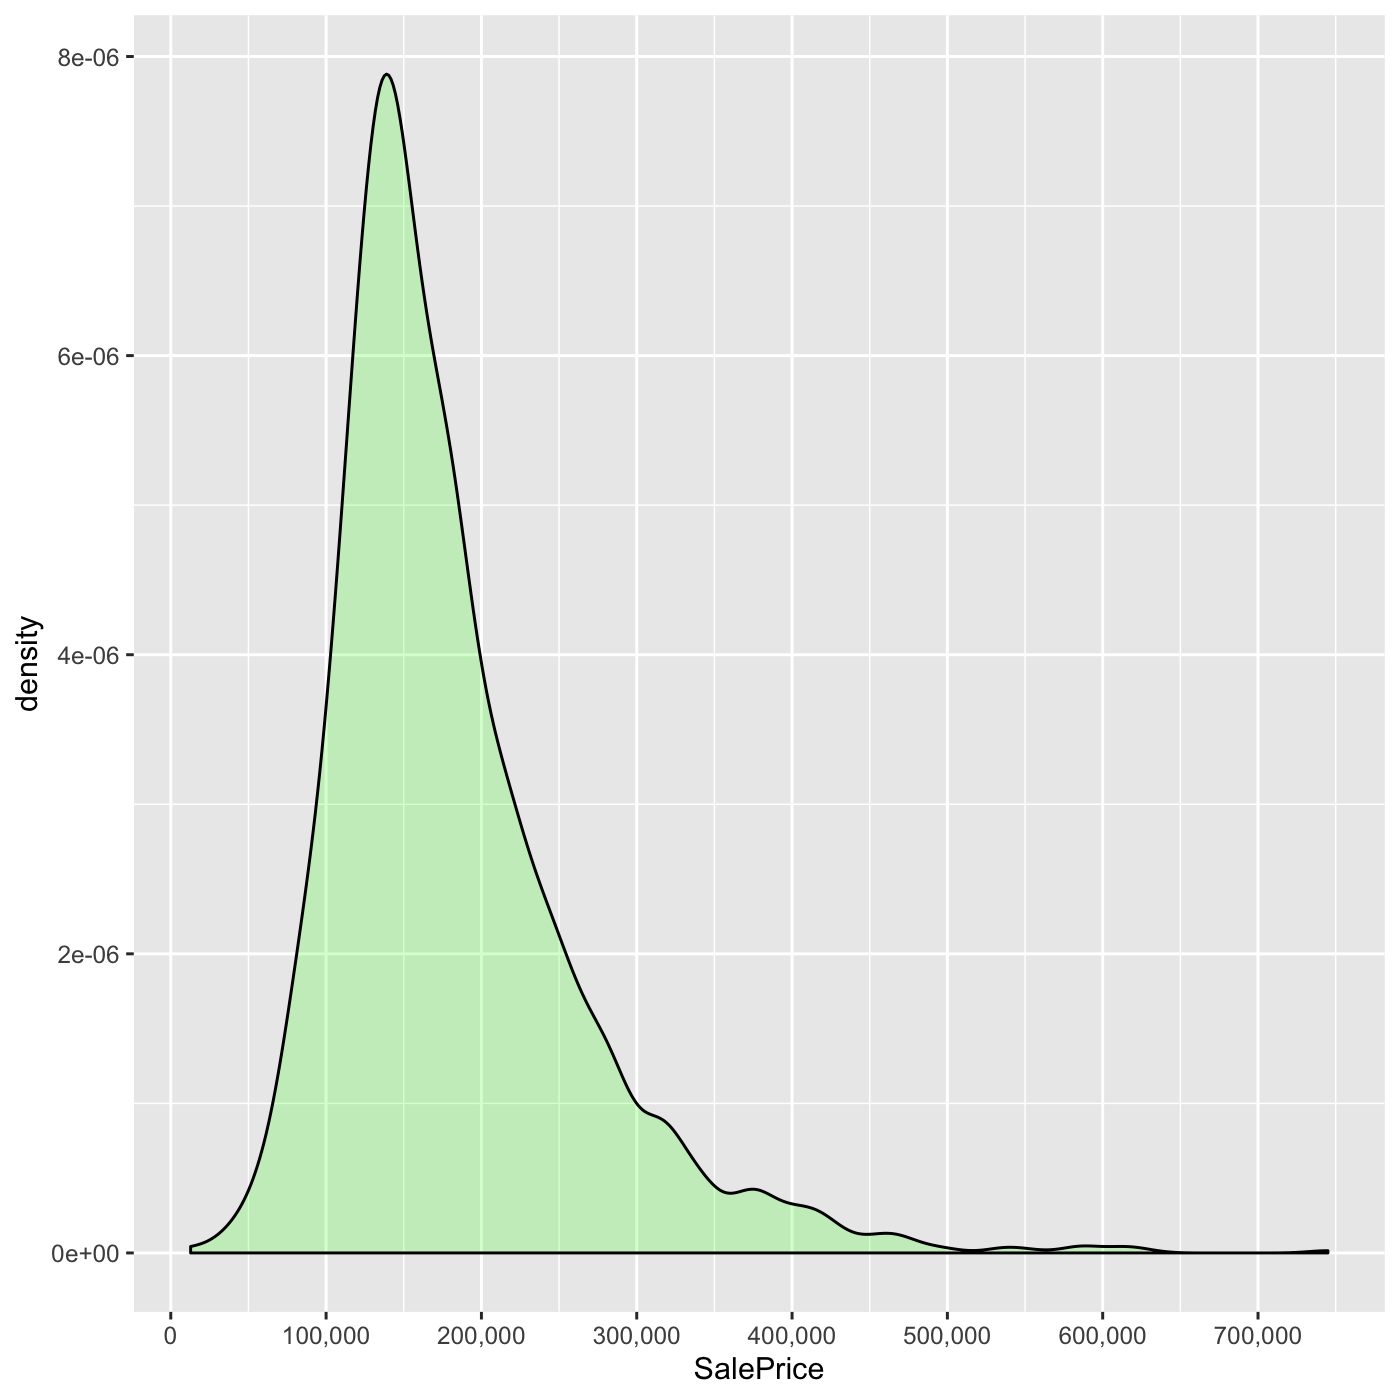

In [27]:
ggplot(train_data) +
    geom_density(aes(x=SalePrice),fill='green',alpha=0.2) +
    scale_x_continuous(breaks = seq(0,800e3, by=100e3), labels = comma)

In [28]:
numeric_data <- select_if(train_data,is.numeric)

In [29]:
head(numeric_data)

Order,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,⋯,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,141,31770,6,5,1960,1960,112,639,0,⋯,210,62,0,0,0,0,0,5,2010,215000
2,80,11622,5,6,1961,1961,0,468,144,⋯,140,0,0,0,120,0,0,6,2010,105000
3,81,14267,6,6,1958,1958,108,923,0,⋯,393,36,0,0,0,0,12500,6,2010,172000
4,93,11160,7,5,1968,1968,0,1065,0,⋯,0,0,0,0,0,0,0,4,2010,244000
5,74,13830,5,5,1997,1998,0,791,0,⋯,212,34,0,0,0,0,0,3,2010,189900
6,78,9978,6,6,1998,1998,20,602,0,⋯,360,36,0,0,0,0,0,6,2010,195500


In [30]:
cut_off <- 0.5

In [34]:
var_correlations <- as.data.frame(cor(numeric_data, use = 'pairwise.complete.obs')) %>%
                filter(abs(SalePrice)> cut_off) %>%
                select_if(~abs(tail(.,1)) > cut_off)

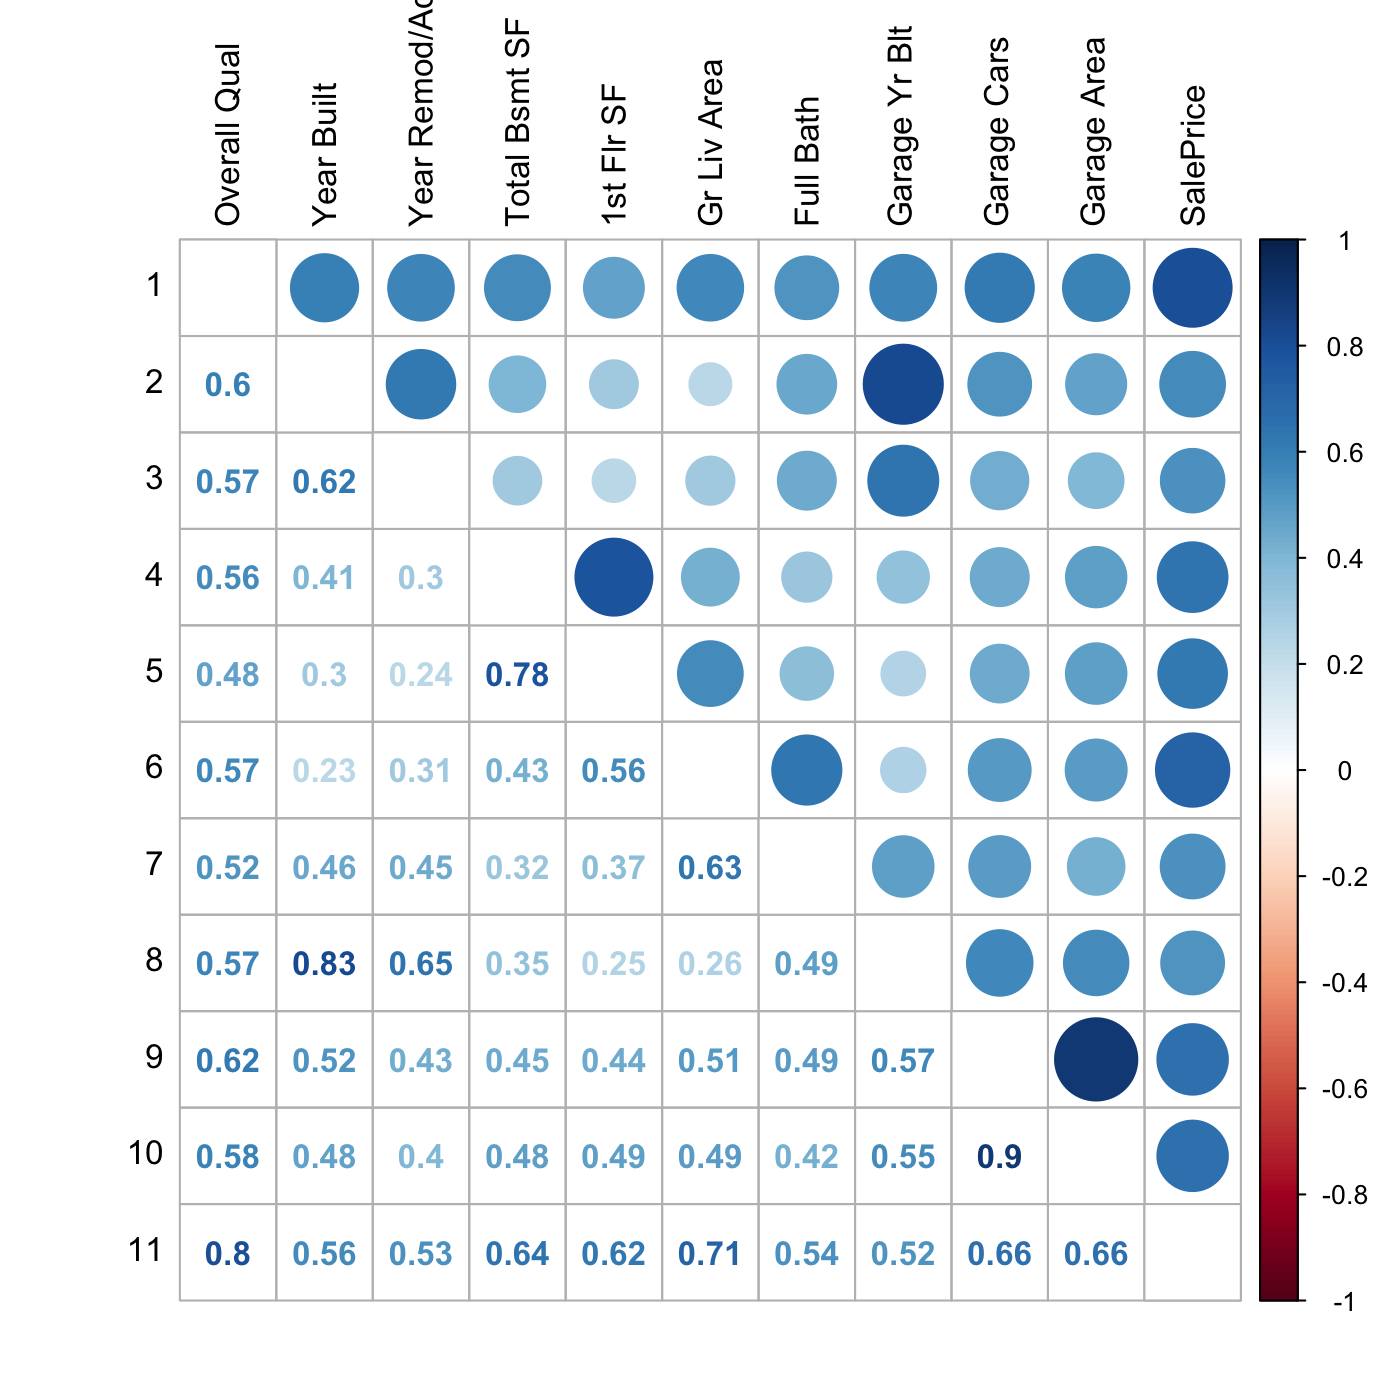

In [40]:
corrplot.mixed(as.matrix(var_correlations),
              tl.col='black',tl.pos = 'lt')

In [41]:
select_if(train_data, is.character) %>%
    dim()

[1] 2199   45

In [43]:
table(train_data$`Land Contour`)


 Bnk  HLS  Low  Lvl 
  83   96   45 1975 

In [45]:
select_if(train_data, is.character) %>%
    summarise_all(~n_distinct(.)) %>%
    pivot_longer(everything(), names_to = 'column', values_to = 'n_distinct')

column,n_distinct
<chr>,<int>
PID,2199
MS SubClass,15
MS Zoning,7
Street,2
Alley,3
Lot Shape,4
Land Contour,4
Utilities,2
Lot Config,5


In [47]:
complete_data <- select_if(train_data, function(x) all(!is.na(x))) %>%
                           remove_rownames() %>%
                        select(-Order, -PID)
complete_data

MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,⋯,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
020,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,⋯,0,0,0,0,0,5,2010,WD,Normal,215000
020,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,⋯,0,0,120,0,0,6,2010,WD,Normal,105000
020,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,⋯,0,0,0,0,12500,6,2010,WD,Normal,172000
020,RL,11160,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,⋯,0,0,0,0,0,4,2010,WD,Normal,244000
060,RL,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,⋯,0,0,0,0,0,3,2010,WD,Normal,189900
060,RL,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,⋯,0,0,0,0,0,6,2010,WD,Normal,195500
120,RL,4920,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,⋯,170,0,0,0,0,4,2010,WD,Normal,213500
120,RL,5389,Pave,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,⋯,0,0,0,0,0,3,2010,WD,Normal,236500
060,RL,7500,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,⋯,0,0,0,0,0,6,2010,WD,Normal,189000


In [55]:
findCorrelation(cor(select_if(complete_data, is.numeric)),cutoff = 0.75)

[1] 29 13 10

In [57]:
findLinearCombos(select_if(complete_data, is.numeric))

$linearCombos
$linearCombos[[1]]
[1] 9 6 7 8

$linearCombos[[2]]
[1] 13 10 11 12


$remove
[1]  9 13

In [64]:
complete_data_dum <- model.matrix(SalePrice ~ ., data = complete_data)
complete_data_dum <- bind_cols(as.data.frame(complete_data_dum), select(complete_data,SalePrice))

In [73]:
table(train_data$Street)


Grvl Pave 
   7 2192 

In [67]:
skim(train_data)

── Data Summary ────────────────────────
                           Values    
Name                       train_data
Number of rows             2199      
Number of columns          82        
_______________________              
Column type frequency:               
  character                45        
  numeric                  37        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
   skim_variable  n_missing complete_rate   min   max empty n_unique whitespace
 1 PID                    0       1          10    10     0     2199          0
 2 MS SubClass            0       1           3     3     0       15          0
 3 MS Zoning              0       1           2     7     0        7          0
 4 Street                 0       1           4     4     0        2          0
 5 Alley               2061       0.0628      4     4     0        2          0
 6 Lot Shape     

In [74]:
nzv <- nearZeroVar(complete_data_dum, saveMetrics = F)

In [76]:
complete_data_dum_var <- complete_data_dum[,-nzv]

In [79]:
set.seed(1234)

train_size = 0.8

train_index <- createDataPartition(y = complete_data_dum_var$SalePrice,
                                  p = train_size,
                                  list = F,
                                  time = 1)

train1 <- complete_data_dum_var[train_index,]
test1 <- complete_data_dum_var[-train_index,]


In [82]:
fitControl <- trainControl(method = 'cv', number = 10, savePredictions = T)

test_model <- train(
                    x = select(complete_data_dum_var, -SalePrice),
                    y = log(complete_data_dum_var$SalePrice),
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

In [83]:
test_model

glmnet 

2199 samples
  71 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1980, 1980, 1978, 1978, 1979, 1978, ... 
Resampling results across tuning parameters:

  alpha  lambda        RMSE       Rsquared   MAE       
  0.10   0.0006786765  0.1382111  0.8876923  0.09039050
  0.10   0.0067867648  0.1376090  0.8886355  0.09001451
  0.10   0.0678676477  0.1425649  0.8830071  0.09431946
  0.55   0.0006786765  0.1379174  0.8882363  0.09024249
  0.55   0.0067867648  0.1385823  0.8871264  0.09135143
  0.55   0.0678676477  0.1681805  0.8545511  0.11459008
  1.00   0.0006786765  0.1377284  0.8885655  0.09007462
  1.00   0.0067867648  0.1406610  0.8842213  0.09314937
  1.00   0.0678676477  0.1931467  0.8200133  0.13644757

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.006786765.

In [84]:
complete_data_dum_var <- complete_data_dum_var %>%
            mutate(SalePrice = log(SalePrice))

In [86]:
lc_data <- 
    learning_curve_dat (
                    dat = complete_data_dum_var,
                    outcome = 'SalePrice',
                    test_prop = 0.25,
                    method = 'glmnet',
                    trControl = fitControl,
                    metric = 'RMSE')

Training for 10% (n = 165)
Training for 20% (n = 330)
Training for 30% (n = 495)
Training for 40% (n = 660)
Training for 50% (n = 825)
Training for 60% (n = 990)
Training for 70% (n = 1155)
Training for 80% (n = 1320)
Training for 90% (n = 1485)
Training for 100% (n = 1651)


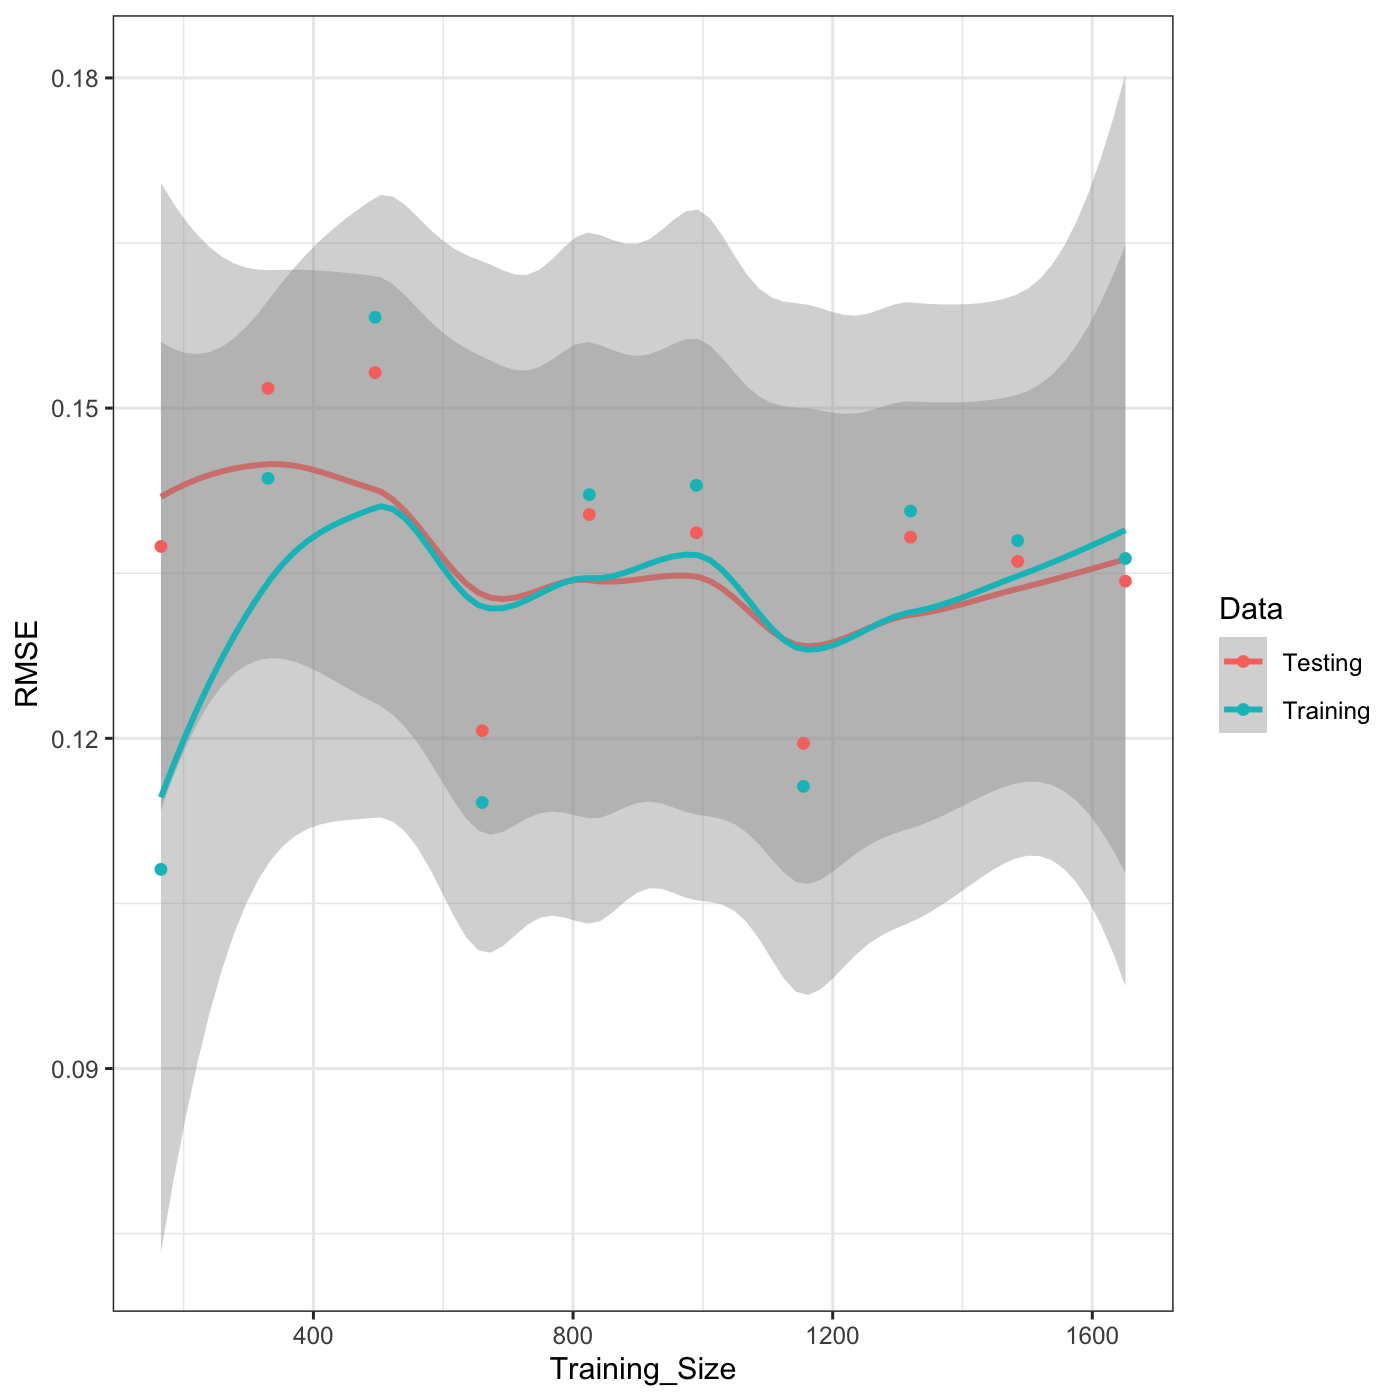

In [92]:
ggplot(filter(lc_data, Data != 'Resampling'), aes(x= Training_Size, y = RMSE, color = Data)) +
        geom_smooth(method = loess, span =0.8) +
        geom_point() +
        theme_bw()